## Image Segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import zipfile
import cv2

In [3]:
path = Path('/storage')
path_lbl = path/'vocal_chords_and_rings_data/data/labels'
path_img = path/'vocal_chords_and_rings_data/data/images'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/vocal_chords_and_rings_data/data/images/472d6b31-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/images/eed4e11f-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/images/07496dbb-0000000.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage/vocal_chords_and_rings_data/data/labels/472d6b31-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/labels/eed4e11f-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/labels/07496dbb-0000000.png')]

# Define Codes and get_y_fn

In [6]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [7]:
codes = np.loadtxt(path_lbl/'../../codes.txt', dtype=str); codes

array(['everything_else', 'vocal_cord', 'trachea_ring', 'bifurcation'], dtype='<U15')

In [8]:
img_f = fnames[8]

# Look at data

PosixPath('/storage/vocal_chords_and_rings_data/data/images/1753e9b9-0000000.png')

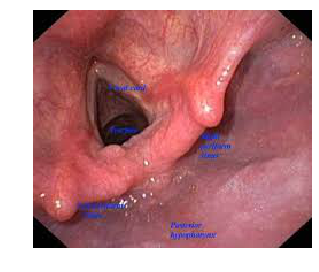

In [9]:
img_f = fnames[8]
img = open_image(img_f)
img.show(figsize=(5,5))
img_f

Make function that returns the label corresponding to a given image (i.e. the ground truth)

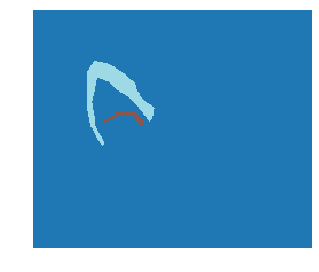

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
np_mask = np.array(mask.data)
src_size, mask.data

(array([207, 243]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
np.unique(np_mask)

array([0, 1, 2])

## Datasets

In [13]:
# size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16268MB of GPU RAM free


In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (104 items)
x: SegmentationItemList
Image (3, 201, 251),Image (3, 480, 720),Image (3, 206, 244),Image (3, 186, 270),Image (3, 176, 286)
y: SegmentationLabelList
ImageSegment (1, 201, 251),ImageSegment (1, 480, 720),ImageSegment (1, 206, 244),ImageSegment (1, 186, 270),ImageSegment (1, 176, 286)
Path: /storage/vocal_chords_and_rings_data/data/images;

Valid: LabelList (19 items)
x: SegmentationItemList
Image (3, 144, 256),Image (3, 137, 324),Image (3, 194, 259),Image (3, 480, 720),Image (3, 203, 300)
y: SegmentationLabelList
ImageSegment (1, 144, 256),ImageSegment (1, 137, 324),ImageSegment (1, 194, 259),ImageSegment (1, 480, 720),ImageSegment (1, 203, 300)
Path: /storage/vocal_chords_and_rings_data/data/images;

Test: None

In [15]:
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

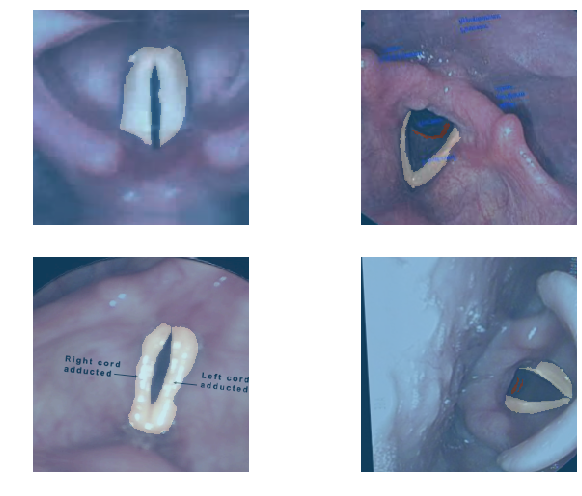

In [16]:
data.show_batch(2, figsize=(10,7))

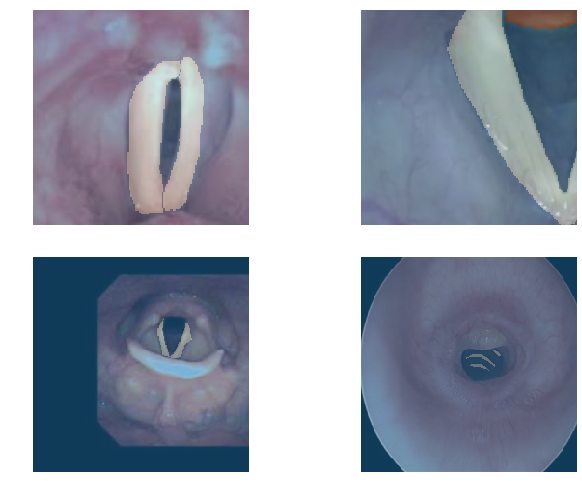

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

Make a custom accuracy metric

In [18]:
def acc_trachea(input, target):
#     print ("Input size: {}".format(input.size(0)))
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()



#     return (x.argmax(dim=1)==target and x[1][x.argmax(dim=1)]==1).float().mean()*weight[1] + (x.argmax(dim=1)==target and x[1][x.argmax(dim=1)]==2).float().mean()*weight[2]

In [19]:
metrics=acc_trachea
# metrics=accuracy

In [20]:
wd=1e-2

In [21]:
#Assign weights to each of the classes
# everything_else_w=1
# vocal_chord_w=10
# trachea_ring_w=10

#Define FocalLoss
# torch.cuda.IntTensor()
# weights = torch.cuda.as_tensor(np.array([everything_else_w, vocal_chord_w, trachea_ring_w]))
# loss_focal = torch.nn.CrossEntropyLoss(weight=weights)

In [22]:
# from torch import nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.logits = logits
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         if self.logits:
#             BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         else:
#             BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction is None:
#             return F_loss
#         else:
#             return torch.mean(F_loss)

In [67]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0].float()
    ret = torch.tensor(2. * torch.sum(m1*m2) / torch.sum(m1+m2), requires_grad=True)
    return ret

def focal_loss(pred, target, gamma=0):
    pred /= torch.sum(pred, dim=-1, keepdim=True)
    eps = 1e-07
    pred = torch.clamp(pred, eps, 1. - eps)
    return -torch.sum(torch.pow(1. - pred, gamma) * target * torch.log(pred))/(target.shape[1]*target.shape[2])

def cross_entr(pred, target):
    return CrossEntropyFlat(pred, target, weight=torch.tensor[1,1,1])

def multi_acc(logits, targets):
    bs, c, h, w = logits.size()
    out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
    input_ = out2.view(bs*h*w,c)

    # target for cross entropy
    _, idx = torch.max(targets, 1)
    target = idx.view(-1)

    return sum(torch.max(input_, dim=0)[1] == target) / len(target)

In [68]:
??nn.CrossEntropyLoss

In [69]:
inp = torch.tensor(np.arange(27).reshape(3,3,3)).float()
inp

targ = torch.tensor(np.arange(27).reshape(3,3,3)).float()
targ

loss = focal_loss(inp,targ)
loss

tensor(42.6059)

In [70]:
# since I am training on multiclass data, loss_fn will be different
from torch import nn
import torch.nn.functional as F
import numpy as np

class MulticlassBCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self):
        super(MulticlassBCELoss2d, self).__init__()
        
    def forward(self, logits, targets):
        # input for cross entropy
        bs, c, h, w = logits.size()
        out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
        input_ = out2.view(bs*h*w,c)
        
        # target for cross entropy
        _, idx = torch.max(targets, 1)
        target = idx.view(-1)
        #return F.cross_entropy(input_, target, weight=torch.tensor([1,100,100]).float())
        return focal_loss(input_, target)

In [71]:
# targ = torch.stack([torch.ones(3,3)*0, torch.ones(3,3)*0, torch.ones(3,3)], dim=0)[None, :]
# inp = torch.stack([torch.ones(3,3)*0.3, torch.ones(3,3)*0.3, torch.ones(3,3)*0.4], dim=0)[None, :]
# inp, targ;

In [72]:
# loss = MulticlassBCELoss2d()
# loss(inp, targ)
# F.softmax(inp)
# - np.log(0.3559)
# # multi_acc(inp, targ)

In [23]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# learn.crit = MulticlassBCELoss2d()
# learn.loss_func = mask_loss
# learn.metrics=[acc_trachea]
# learn.crit=cross_entr
# learn.opt_fn=optim.Adam

In [74]:
# lr_find(learn)
# learn.recorder.plot()
# learn.metrics=[acc_trachea]

In [76]:
# learn.crit=learn.loss_func
# learn.loss_func, learn.crit
# ??learn.loss_func
# CrossEntropyFlat
# ??learn.loss_func
# learn.crit = CrossEntropyFlat(weight=torch.tensor[1,1,1])
# ??FlattenedLoss


This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.

    It is useful when training a classification problem with `C` classes.
    If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
    assigning weight to each of the classes.
    This is particularly useful when you have an unbalanced training set.

    The `input` is expected to contain scores for each class.

    `input` has to be a Tensor of size either :math:`(minibatch, C)` or
    :math:`(minibatch, C, d_1, d_2, ..., d_K)`
    with :math:`K \geq 2` for the `K`-dimensional case (described later).

    This criterion expects a class index (0 to `C-1`) as the
    `target` for each value of a 1D tensor of size `minibatch`

    The loss can be described as:

    .. math::
        \text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                       = -x[class] + \log\left(\sum_j \exp(x[j])\right)

    or in the case of the `weight` argument being specified:

    .. math::
        \text{loss}(x, class) = weight[class] \left(-x[class] + \log\left(\sum_j \exp(x[j])\right)\right)

    The losses are averaged across observations for each minibatch.

    Can also be used for higher dimension inputs, such as 2D images, by providing
    an input of size :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 2`,
    where :math:`K` is the number of dimensions, and a target of appropriate shape
    (see below).


    Args:
        weight (Tensor, optional): a manual rescaling weight given to each class.
            If given, has to be a Tensor of size `C`
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when reduce is ``False``. Default: ``True``
        ignore_index (int, optional): Specifies a target value that is ignored
            and does not contribute to the input gradient. When `size_average` is
            ``True``, the loss is averaged over non-ignored targets.
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: 'mean'

    Shape:
        - Input: :math:`(N, C)` where `C = number of classes`, or
            :math:`(N, C, d_1, d_2, ..., d_K)` with :math:`K \geq 2`
            in the case of `K`-dimensional loss.
        - Target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`, or
            :math:`(N, d_1, d_2, ..., d_K)` with :math:`K \geq 2` in the case of
            K-dimensional loss.
        - Output: scalar. If reduce is ``False``, then the same size
            as the target: :math:`(N)`, or
            :math:`(N, d_1, d_2, ..., d_K)` with :math:`K \geq 2` in the case
            of K-dimensional loss.

    Examples::

        >>> loss = nn.CrossEntropyLoss()
        >>> input = torch.randn(3, 5, requires_grad=True)
        >>> target = torch.empty(3, dtype=torch.long).random_(5)
        >>> output = loss(input, target)
        >>> output.backward()

In [77]:
# class Empty(nn.Module):
#     def forward(self, x): return x

# # models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
# learn = cnn_learner(md, models.)
# learn.summary()

# class StdUpsample(nn.Module):
#     def __init__(self, nin, nout):
#         super().__init__()
#         self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
#         self.bn = nn.BatchNorm2d(nout)

#     def forward(self, x): return self.bn(F.relu(self.conv(x)))

# flatten_channel = Lambda(lambda x: x[:, 0])

# simple_up = nn.Sequential(
#     nn.ReLU(),
#     StdUpsample(512, 256),
#     StdUpsample(256, 256),
#     StdUpsample(256, 256),
#     StdUpsample(256, 256),
#     nn.ConvTranspose2d(256, 1, 2, stride=2),
#     flatten_channel
# )

In [78]:
# ??focal_loss
# ??MSELossFlat

In [79]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# ??learn.loss_func

In [80]:
# learn.crit=CrossEntropyFlat(weight = Tensor([1.] * data.c))
# learn.loss_func = FlattenedLoss(nn.CrossEntropyLoss())

In [81]:
# learn.loss_func = CrossEntropyFlat()#focal_loss#FlattenedLoss(nn.CrossEntropyLoss()) ## Variable(focal_loss, requires_grad = True)
# Learner.
# learn.data.batch_size
# learn.lossfunc = CrossEntropyFlat()
# ??CrossEntropyFlat()

In [82]:
# learn.loss = MSELossFlat()
# ??MSELossFlat()
# import torch

# # learn.loss_func=torch.nn.CrossEntropyLoss()
# learn.loss_func

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


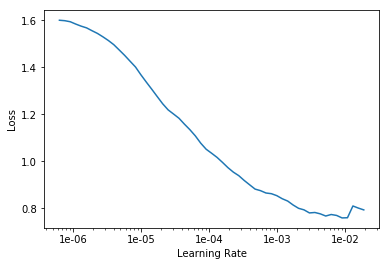

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.624799,0.533926,0.871769,00:06
1,0.506695,0.456801,0.872551,00:04
2,0.445994,0.318271,0.881609,00:04
3,0.421119,0.362297,0.872844,00:04
4,0.384891,0.298016,0.902279,00:04
5,0.377574,0.371932,0.872518,00:04
6,0.358846,0.324756,0.894465,00:04
7,0.358925,0.530795,0.875099,00:04
8,0.344225,0.331902,0.891145,00:04
9,0.329973,0.269787,0.895670,00:04


In [25]:
learn.save('stage-1-custom-0606')

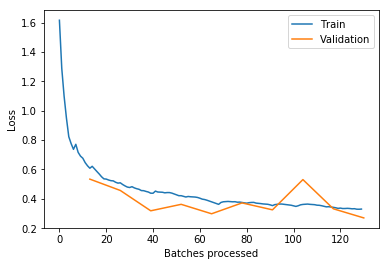

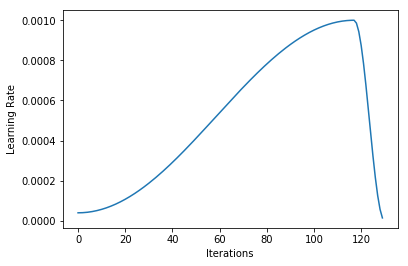

In [26]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [334]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()

In [335]:
# learn.load('stage-1-custom');

In [336]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()

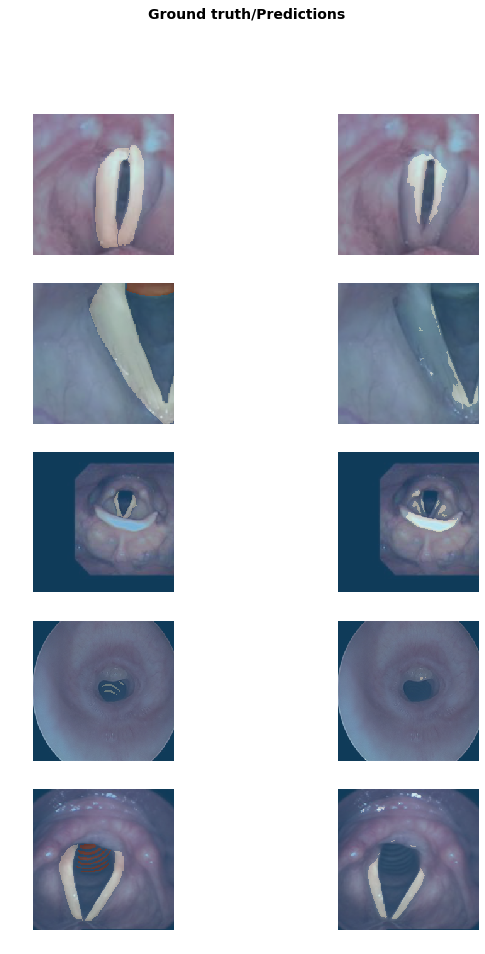

In [27]:
learn.show_results(rows=5, figsize=(10,15))

In [128]:
learn.unfreeze()

In [129]:
lrs = slice(lr/400,lr/4)

In [130]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.138815,0.168692,0.941573,00:27
1,0.134157,0.165569,0.941887,00:04
2,0.134393,0.168660,0.944721,00:04
3,0.133033,0.161798,0.944723,00:04
4,0.132447,0.157425,0.944264,00:04
5,0.130332,0.184072,0.943910,00:04
6,0.130956,0.173646,0.946572,00:04
7,0.124259,0.156999,0.949856,00:04
8,0.118571,0.139022,0.949291,00:06
9,0.113031,0.130639,0.954209,00:04


In [131]:
learn.save('stage-2-custom-focal', return_path=True)

PosixPath('/storage/vocal_chords_and_rings_data/data/images/models/stage-2-custom-focal.pth')

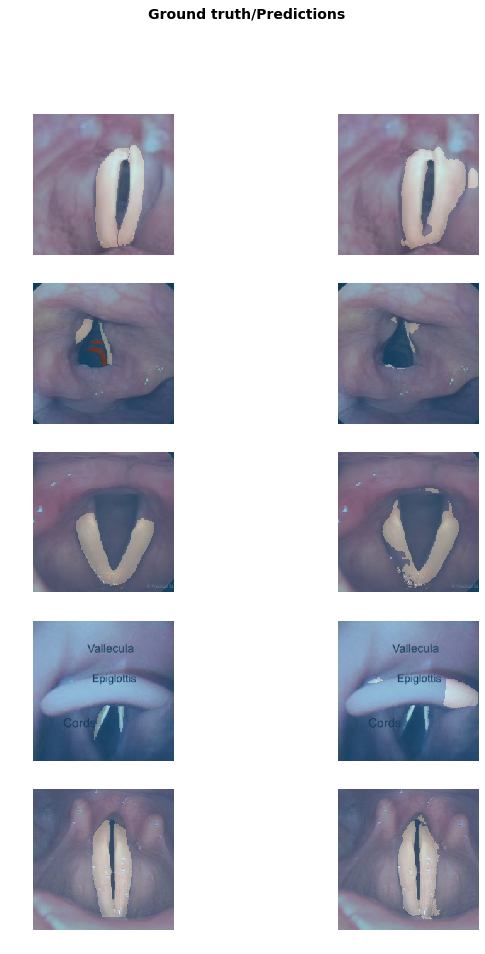

In [132]:
learn.show_results(rows=5, figsize=(10,15))

## Go big

In [133]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 13773MB of GPU RAM free


In [134]:
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [135]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [136]:
learn.load('stage-2-custom-focal');

In [137]:
# learn.crit = MulticlassBCELoss2d()
# # learn.loss_func = mask_loss
# learn.metrics=[acc_trachea]
# learn.opt_fn=optim.Adam

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


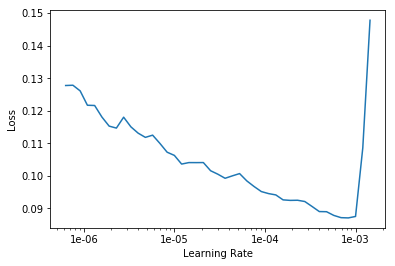

In [138]:
lr_find(learn)
learn.recorder.plot()

In [139]:
lr=1e-5

In [140]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.105641,0.144610,0.946187,00:09
1,0.102371,0.131664,0.950583,00:04
2,0.096283,0.134214,0.951066,00:04
3,0.094032,0.123625,0.954371,00:04
4,0.092150,0.126013,0.954527,00:04
5,0.091474,0.135682,0.952669,00:05
6,0.088012,0.136295,0.952338,00:04
7,0.084216,0.120981,0.956655,00:05
8,0.086567,0.131155,0.954508,00:04
9,0.083474,0.124341,0.954393,00:04


In [141]:
learn.save('stage-1-big-focal')

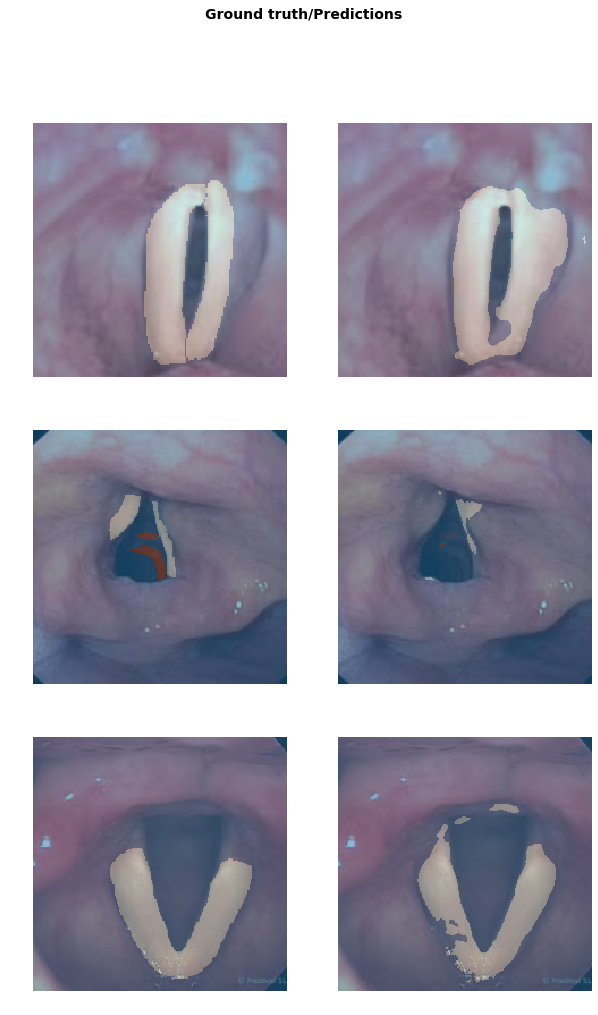

In [142]:
learn.show_results(rows=5, figsize=(10,16))

In [49]:
learn.load('stage-1-big-focal');

In [143]:
learn.unfreeze()

In [144]:
lrs = slice(1e-6,lr/10)

In [145]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.084095,0.123446,0.955422,00:05
1,0.085827,0.118649,0.956112,00:05
2,0.083984,0.132404,0.952978,00:06
3,0.087040,0.126598,0.957184,00:17
4,0.084762,0.123036,0.956341,00:05
5,0.091129,0.136866,0.952062,00:05
6,0.082524,0.151180,0.947465,00:05
7,0.083269,0.136951,0.953084,00:05
8,0.083617,0.133201,0.953431,00:05
9,0.087548,0.129039,0.956879,00:06


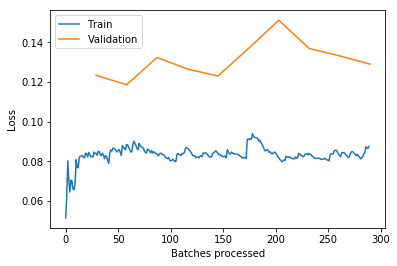

In [146]:
learn.recorder.plot_losses()

In [184]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [147]:
learn.save('stage-2-big-focal', return_path=True)

PosixPath('/storage/vocal_chords_and_rings_data/data/images/models/stage-2-big-focal.pth')

In [1]:
learn.load('stage-2-big-focal');

NameError: name 'learn' is not defined

## Final Results

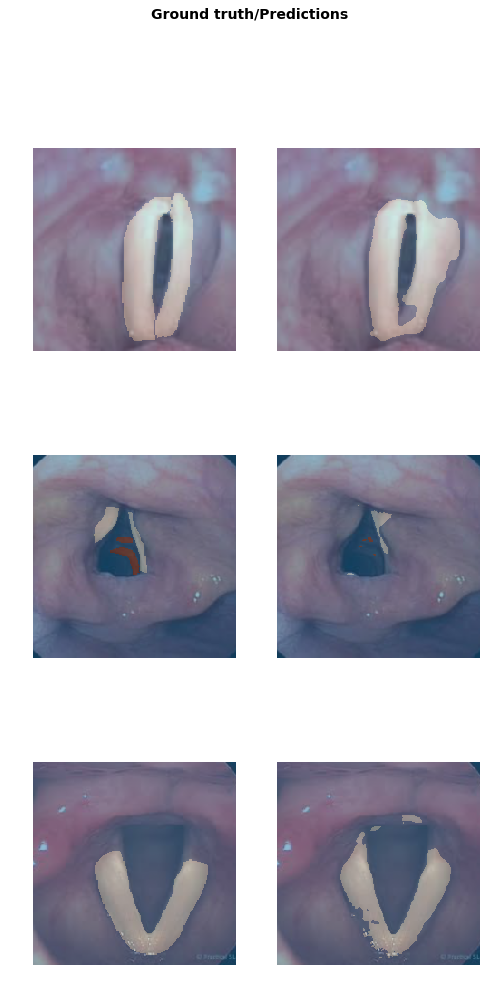

In [154]:
learn.show_results(rows=10, figsize=(8,16))

Prediction time: 0.030638694763183594


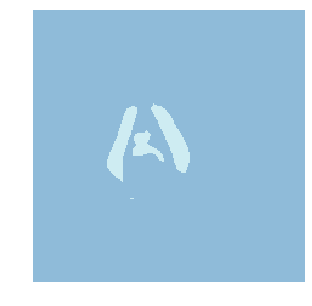

In [151]:
import time

img = open_image('/storage/vocal_chords_and_rings_data/data/images/bc9cd224-0000000.png')
start = time.time()
prediction = learn.predict(img)
end = time.time()
print("Prediction time: {}".format(end - start))
prediction[0].show(figsize=(5,5))

# ??learn.predict

In [32]:
learn.load('stage-2-big') # or whatever your saved model is
example = torch.rand(2, 3, 224, 224) # dummy batch size, n_chanels, w, h
learn.model.training = False # disable dropout
learn.model = learn.model.cpu() # move to CPU

In [34]:
#traced_script_module = torch.jit.trace(learn.model, example)
# traced_script_module.save("model.pt")

## Closing notes:

Architecture: U-Net with (ResNet34 for encoder)

Training Dataset Size: 88 imgs

Validation Dataset Size: 16 imgs

Prediction time: ~3ms

Accuracy: 97.45%

In [29]:
from fastai.datasets import *

Object ` fastai.datasets` not found.
